# Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tkinter as tk
import seaborn as sns
from PIL import Image, ImageTk
from skimage import feature
import matplotlib.pyplot as plt
from tkinter import filedialog, ttk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization

2023-10-31 00:34:28.660232: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 00:34:28.660303: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 00:34:28.668378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 00:34:29.604095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Pre-procesamiento del Dataset

In [2]:
BASE_DIR = './UTKFace'

image_paths = []
age_labels = []

i = 0
for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    image_paths.append(image_path)

    temp = filename.split('_')
    age = int(temp[0])
    age_labels.append(age)
    i+=1

df = pd.DataFrame()
df['image'], df['age'] = image_paths, age_labels
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23708 non-null  object
 1   age     23708 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 370.6+ KB


In [3]:
df.head()

,image,age
0,./UTKFace/82_0_0_20170111222551270.jpg.chip.jpg,82
1,./UTKFace/3_1_2_20161219153312836.jpg.chip.jpg,3
2,./UTKFace/42_0_0_20170105161358787.jpg.chip.jpg,42
3,./UTKFace/36_0_3_20170117183126213.jpg.chip.jpg,36
4,./UTKFace/55_0_2_20170104023125269.jpg.chip.jpg,55


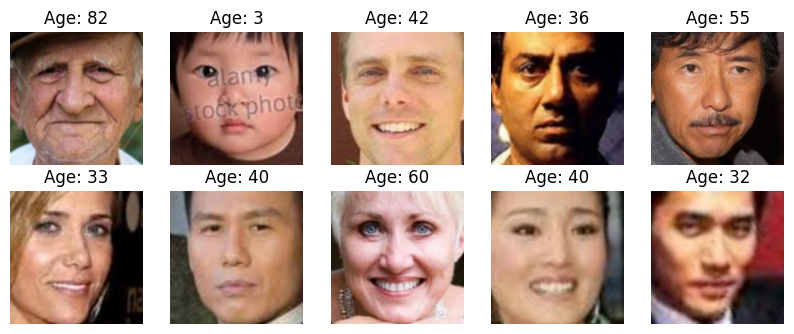

In [4]:
plt.figure(figsize=(10, 10))
files = df.iloc[0:10]

for index, file, age in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

<Axes: xlabel='age', ylabel='Count'>

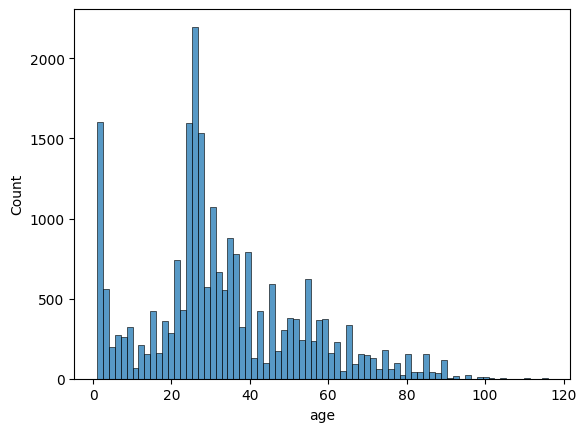

In [5]:
sns.histplot(df['age'])

# Feature Engineering

In [4]:
def image_processing(images):
    features = []
    for image in images:
        img = load_img(image, color_mode="grayscale")
        img = img.resize((128, 128), Image.NONE)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

X_raw = image_processing(df['image'])
np.shape(X_raw)

(23708, 128, 128, 1)

# Feature Extractor

### HoG (Histogram of Oriented Gradients)

In [5]:
X_hog = []

for i in range(len(X_raw)):
    # Compute HOG features
    hog_features = feature.hog(X_raw[i, :, :, 0], orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)

    X_hog.append(hog_features)

X_hog = np.array(X_hog)

### Bilateral Filter

In [6]:
X_bilateral = []

for i in range(len(X_raw)):
    img = X_raw[i, :, :, 0]
    img = cv2.bilateralFilter(img, 9, 75, 75)
    X_bilateral.append(img)

X_bilateral = np.array(X_bilateral)

# División en Train / Test Sets

In [ ]:
print(X_raw.shape)
print(X_hog.shape)
print(X_bilateral.shape)

(23708, 128, 128, 1)
(23708, 512)
(23708, 128, 128)


In [7]:
y = np.array(df['age'])

# División de set de datos
# Imágenes crudas
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# Imágenes con Feature Extractor)
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(X_hog, y, test_size=0.2, random_state=42)

# Imágenes con Bilateral Filter
X_train_bilat, X_test_bilat, y_train_bilat, y_test_bilat = train_test_split(X_bilateral, y, test_size=0.2, random_state=42)

## Encoding según grupo de edad

In [8]:
y_train_raw_group = []
y_test_raw_group = []
y_train_bilat_group = []
y_test_bilat_group = []
y_train_hog_group = []
y_test_hog_group = []

def encode_ages(new_list, ages):
    for age in ages:
        if age < 12:
            new_list.append(0)
        elif age < 19:
            new_list.append(1)
        elif age < 60:
            new_list.append(2)
        else:
            new_list.append(3)
    return np.array(new_list)

# raw images
y_train_raw_group = encode_ages(y_train_raw_group, y_train_raw)
y_test_raw_group = encode_ages(y_test_raw_group, y_test_raw)
# HoG images
y_train_hog_group = encode_ages(y_train_hog_group, y_train_hog)
y_test_hog_group = encode_ages(y_test_hog_group, y_test_hog)
# bilateral filter images
y_train_bilat_group = encode_ages(y_train_bilat_group, y_train_bilat)
y_test_bilat_group = encode_ages(y_test_bilat_group, y_test_bilat)

# MLP

## Sin Feature Extractor

### Entrenamiento

In [11]:
mlp_raw = Sequential([
    Flatten(input_shape=(128, 128)),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.0001)
mlp_raw.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

history = mlp_raw.fit(X_train_raw, y_train_raw, validation_split=0.2, epochs=70, batch_size=32)

Epoch 1/70
376/475 [======================>.......] - ETA: 0s - loss: 423.8550 - mae: 15.7106

KeyboardInterrupt: 

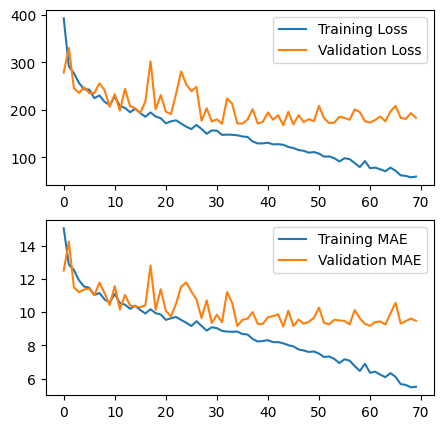

In [91]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()

### Predicción de Edad

In [10]:
y_pred = mlp_raw.predict(X_test_raw)
y_pred_train = mlp_raw.predict(X_train_raw)

mlp_raw_test_mae = mean_absolute_error(y_test_raw, y_pred)
mlp_raw_train_mae = mean_absolute_error(y_train_raw, y_pred_train)
mlp_raw_test_mse = mean_squared_error(y_test_raw, y_pred)
mlp_raw_train_mse = mean_squared_error(y_train_raw, y_pred_train)

print(f"Test MAE: {mlp_raw_test_mae}")
print(f"Train MAE: {mlp_raw_train_mae}")
print(f"Test MSE: {mlp_raw_test_mse}")
print(f"Train MSE: {mlp_raw_train_mse}")

593/593 [==============================] - 2s 3ms/step
Test MAE: 9.028824104683553
Train MAE: 7.772451880485288
Test MSE: 164.59154277366014
Train MSE: 117.79242274113903


In [11]:
df_test = pd.DataFrame()
df_test['Real Ages'] = y_test_raw
df_test['Predicted Ages'] = y_pred
df_test['MAE'] = abs(df_test['Real Ages'] - df_test['Predicted Ages'])
df_test['MSE'] = (df_test['Real Ages'] - df_test['Predicted Ages'])**2
df_test.head(10)

,Real Ages,Predicted Ages,MAE,MSE
0,38,35.507809,2.492191,6.211018
1,10,26.298588,16.298588,265.643964
2,24,35.637459,11.637459,135.430447
3,56,46.766209,9.233791,85.262903
4,53,59.636547,6.636547,44.043757
5,28,33.587395,5.587395,31.218980
6,47,44.074799,2.925201,8.556803
7,18,28.061815,10.061815,101.240126
8,57,39.675930,17.324070,300.123401
9,36,46.410500,10.410500,108.378501


### Clasificación en grupos de edad

In [12]:
y_pred_group = []
y_train_pred_group = []

y_pred_group = encode_ages(y_pred_group, y_pred)
y_train_pred_group = encode_ages(y_train_pred_group, y_pred_train)

mlp_raw_accuracy = accuracy_score(y_test_raw_group, y_pred_group)
mlp_raw_precision = precision_score(y_test_raw_group, y_pred_group, average='weighted')
mlp_raw_recall = recall_score(y_test_raw_group, y_pred_group, average='weighted')
mlp_raw_f1 = f1_score(y_test_raw_group, y_pred_group, average='weighted')

accuracy_train = accuracy_score(y_train_raw_group, y_train_pred_group)
precision_train = precision_score(y_train_raw_group, y_train_pred_group, average='weighted')
recall_train = recall_score(y_train_raw_group, y_train_pred_group, average='weighted')
f1_train = f1_score(y_train_raw_group, y_train_pred_group, average='weighted')

results = pd.DataFrame()
results['Test'] = [mlp_raw_accuracy, mlp_raw_precision, mlp_raw_recall, mlp_raw_f1]
results['Train'] = [accuracy_train, precision_train, recall_train, f1_train]
results.index = ['Accuracy', 'Precision', 'Recall', 'F1']
results

,Test,Train
Accuracy,0.810628,0.834968
Precision,0.794162,0.817114
Recall,0.810628,0.834968
F1,0.795666,0.820667


## Con Feature Extractor

### Entrenamiento

In [12]:
mlp_hog = Sequential([
    Flatten(input_shape=(X_hog.shape[1],)),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.0001)
mlp_hog.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

history = mlp_hog.fit(X_train_hog, y_train_hog, validation_split=0.2, epochs=30, batch_size=32)

Epoch 1/30
475/475 [==============================] - 8s 10ms/step - loss: 346.5323 - mae: 14.0732 - val_loss: 207.7832 - val_mae: 11.1970
Epoch 2/30
475/475 [==============================] - 5s 10ms/step - loss: 208.7275 - mae: 11.1476 - val_loss: 208.5451 - val_mae: 11.4141
Epoch 3/30
475/475 [==============================] - 5s 10ms/step - loss: 181.2115 - mae: 10.1251 - val_loss: 164.5987 - val_mae: 9.5491
Epoch 4/30
475/475 [==============================] - 5s 10ms/step - loss: 169.3559 - mae: 9.6354 - val_loss: 163.5477 - val_mae: 9.4936
Epoch 5/30
475/475 [==============================] - 4s 9ms/step - loss: 163.2022 - mae: 9.4289 - val_loss: 155.6550 - val_mae: 9.1601
Epoch 6/30
475/475 [==============================] - 5s 10ms/step - loss: 153.4719 - mae: 9.1018 - val_loss: 150.9600 - val_mae: 8.9096
Epoch 7/30
475/475 [==============================] - 5s 10ms/step - loss: 148.8568 - mae: 8.9446 - val_loss: 183.2297 - val_mae: 9.8897
Epoch 8/30
475/475 [=================

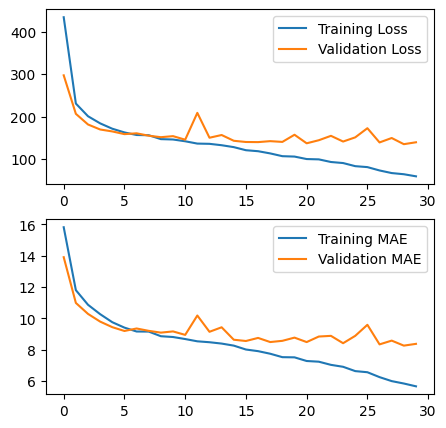

In [14]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()

### Predicción de Edad

In [15]:
y_pred = mlp_hog.predict(X_test_hog)
y_pred_train = mlp_hog.predict(X_train_hog)

mlp_hog_test_mae = mean_absolute_error(y_test_hog, y_pred)
mlp_hog_train_mae = mean_absolute_error(y_train_hog, y_pred_train)
mlp_hog_test_mse = mean_squared_error(y_test_hog, y_pred)
mlp_hog_train_mse = mean_squared_error(y_train_hog, y_pred_train)

print(f"Test MAE: {mlp_hog_test_mae}")
print(f"Train MAE: {mlp_hog_train_mae}")
print(f"Test MSE: {mlp_hog_test_mse}")
print(f"Train MSE: {mlp_hog_train_mse}")

593/593 [==============================] - 2s 3ms/step
Test MAE: 8.348783564223162
Train MAE: 5.8702642055179055
Test MSE: 139.75400019485483
Train MSE: 68.96207474068558


In [16]:
df_test = pd.DataFrame()
df_test['Real Ages'] = y_test_hog
df_test['Predicted Ages'] = y_pred
df_test['MAE'] = abs(df_test['Real Ages'] - df_test['Predicted Ages'])
df_test['MSE'] = (df_test['Real Ages'] - df_test['Predicted Ages'])**2
df_test.head(10)

,Real Ages,Predicted Ages,MAE,MSE
0,38,38.490967,0.490967,0.241048
1,10,28.833790,18.833790,354.711639
2,24,28.217308,4.217308,17.785687
3,56,51.951336,4.048664,16.391681
4,53,46.500755,6.499245,42.240182
5,28,23.012491,4.987509,24.875244
6,47,44.580765,2.419235,5.852699
7,18,26.758736,8.758736,76.715450
8,57,43.991341,13.008659,169.225218
9,36,36.757938,0.757938,0.574471


### Clasificación en grupos de edad

In [17]:
y_pred_group = []
y_train_pred_group = []

y_pred_group = encode_ages(y_pred_group, y_pred)
y_train_pred_group = encode_ages(y_train_pred_group, y_pred_train)

mlp_hog_accuracy = accuracy_score(y_test_hog_group, y_pred_group)
mlp_hog_precision = precision_score(y_test_hog_group, y_pred_group, average='weighted')
mlp_hog_recall = recall_score(y_test_hog_group, y_pred_group, average='weighted')
mlp_hog_f1 = f1_score(y_test_hog_group, y_pred_group, average='weighted')

accuracy_train = accuracy_score(y_train_hog_group, y_train_pred_group)
precision_train = precision_score(y_train_hog_group, y_train_pred_group, average='weighted')
recall_train = recall_score(y_train_hog_group, y_train_pred_group, average='weighted')
f1_train = f1_score(y_train_hog_group, y_train_pred_group, average='weighted')

results = pd.DataFrame()
results['Test'] = [mlp_hog_accuracy, mlp_hog_precision, mlp_hog_recall, mlp_hog_f1]
results['Train'] = [accuracy_train, precision_train, recall_train, f1_train]
results.index = ['Accuracy', 'Precision', 'Recall', 'F1']
results

,Test,Train
Accuracy,0.809574,0.865707
Precision,0.800586,0.856125
Recall,0.809574,0.865707
F1,0.799706,0.857290


# CNN

## Sin Bilateral Filter

### Entrenamiento

In [9]:
cnn1_raw = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(1, activation="linear")
])

optimizer = Adam(learning_rate=0.0001)
cnn1_raw.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
history = cnn1_raw.fit(X_train_raw, y_train_raw, validation_split=0.2, epochs=2, batch_size=8)

2023-10-31 00:40:24.237260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 00:40:24.585268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 00:40:24.585854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/2


2023-10-31 00:40:27.270251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-31 00:40:30.440039: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-31 00:40:33.655050: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-31 00:40:34.633521: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c4818a0b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-31 00:40:34.633577: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2023-10-31 00:40:34.737700: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-31 00:40:35.151926: I ./tensorflow/compiler/jit/devic

1897/1897 [==============================] - 28s 9ms/step - loss: 294.0757 - mae: 12.5541 - val_loss: 170.1982 - val_mae: 9.8974
Epoch 2/2
1897/1897 [==============================] - 16s 8ms/step - loss: 171.7346 - mae: 9.8727 - val_loss: 140.9692 - val_mae: 8.8255


In [ ]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()

### Predicción de Edad

In [ ]:
y_pred = cnn1_raw.predict(X_test_raw)
y_pred_train = cnn1_raw.predict(X_train_raw)

test_mae = mean_absolute_error(y_test_raw, y_pred)
train_mae = mean_absolute_error(y_train_raw, y_pred_train)

print(f"Test MAE: {test_mae}")
print(f"Train MAE: {train_mae}")

In [ ]:
df_test = pd.DataFrame()
df_test['Real Ages'] = y_test_raw
df_test['Predicted Ages'] = y_pred
df_test.head(10)

### Clasificación en grupos de edad

In [ ]:
y_pred_group = []
y_train_pred_group = []

y_pred_group = encode_ages(y_pred_group, y_pred)
y_train_pred_group = encode_ages(y_train_pred_group, y_pred_train)

accuracy = accuracy_score(y_test_raw_group, y_pred_group)
precision = precision_score(y_test_raw_group, y_pred_group, average='weighted')
recall = recall_score(y_test_raw_group, y_pred_group, average='weighted')
f1 = f1_score(y_test_raw_group, y_pred_group, average='weighted')

accuracy_train = accuracy_score(y_train_raw_group, y_train_pred_group)
precision_train = precision_score(y_train_raw_group, y_train_pred_group, average='weighted')
recall_train = recall_score(y_train_raw_group, y_train_pred_group, average='weighted')
f1_train = f1_score(y_train_raw_group, y_train_pred_group, average='weighted')

results = pd.DataFrame()
results['Test'] = [accuracy, precision, recall, f1]
results['Train'] = [accuracy_train, precision_train, recall_train, f1_train]
results.index = ['Accuracy', 'Precision', 'Recall', 'F1']
results

## Con Bilateral Filter

### Entrenamiento

In [ ]:
cnn1_bilat = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128)), #TODO: change to (128, 128, 1)
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), #TODO: add a 256 layer
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='linear') 
])
optimizer = Adam(learning_rate=0.0001)
cnn1_bilat.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

history = cnn1_bilat.fit(X_train_bilat, y_train_bilat, validation_split=0.2, epochs=100, batch_size=64)

In [ ]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()

### Predicción de Edad

In [ ]:
y_pred = cnn1_bilat.predict(X_test_bilat)
y_pred_train = cnn1_bilat.predict(X_train_bilat)

test_mae = mean_absolute_error(y_test_bilat, y_pred)
train_mae = mean_absolute_error(y_train_bilat, y_pred_train)

print(f"Test MAE: {test_mae}")
print(f"Train MAE: {train_mae}")

In [ ]:
df_test = pd.DataFrame()
df_test['Real Ages'] = y_test_bilat
df_test['Predicted Ages'] = y_pred
df_test.head(10)

### Clasificación en grupos de edad

In [ ]:
y_pred_group = []
y_train_pred_group = []

y_pred_group = encode_ages(y_pred_group, y_pred)
y_train_pred_group = encode_ages(y_train_pred_group, y_pred_train)

accuracy = accuracy_score(y_test_bilat_group, y_pred_group)
precision = precision_score(y_test_bilat_group, y_pred_group, average='weighted')
recall = recall_score(y_test_bilat_group, y_pred_group, average='weighted')
f1 = f1_score(y_test_bilat_group, y_pred_group, average='weighted')

accuracy_train = accuracy_score(y_train_bilat_group, y_train_pred_group)
precision_train = precision_score(y_train_bilat_group, y_train_pred_group, average='weighted')
recall_train = recall_score(y_train_bilat_group, y_train_pred_group, average='weighted')
f1_train = f1_score(y_train_bilat_group, y_train_pred_group, average='weighted')

results = pd.DataFrame()
results['Test'] = [accuracy, precision, recall, f1]
results['Train'] = [accuracy_train, precision_train, recall_train, f1_train]
results.index = ['Accuracy', 'Precision', 'Recall', 'F1']
results

# Interfaz Gráfica

In [14]:
models = ["MLP Crudo", "MLP Feature Extractor"]

# Function to predict age
def predict_age():
    # Get the selected model
    selected_model = model_combobox.get()
    
    # Get the selected image file
    file_path = file_entry.get()
    
    if not selected_model or not file_path:
        result_label.config(text="Debe seleccionar un modelo y una imagen.")
        return
    
    # Image processing
    processed_image = image_processing([file_path])
    
    # Load the selected model TODO: update with our models
    # TODO: add filters 
    if selected_model == models[0]:
        loaded_model = mlp_raw
    elif selected_model == models:
        loaded_model = mlp_hog
    
    # Make predictions
    age_prediction = loaded_model.predict(processed_image)
    
    result_label.config(text=f"Edad predicha: {age_prediction[0][0]:.2f} years")

# Create the main window
root = tk.Tk()
root.title("Predicción de Edad")

# Create a label for the file path
file_label = tk.Label(root, text="Seleccione una imagen:")
file_label.pack()

# Entry widget to display the selected file path
file_entry = tk.Entry(root, width=40)
file_entry.pack()

# Browse button to select an image
def browse_file():
    file_path = filedialog.askopenfilename()
    file_entry.delete(0, tk.END)
    file_entry.insert(0, file_path)
    
browse_button = tk.Button(root, text="Buscar...", command=browse_file)
browse_button.pack()

# Create a label for model selection
model_label = tk.Label(root, text="Seleccione un modelo:")
model_label.pack()

# Dropdown for model selection
model_combobox = ttk.Combobox(root, values=models)
model_combobox.pack()

# Button to predict age
predict_button = tk.Button(root, text="Probar modelo", command=predict_age)
predict_button.pack()

# Label to display the prediction result
result_label = tk.Label(root, text="")
result_label.pack()

# Start the main event loop
root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/tmp/ipykernel_2901/4013489459.py", line 44, in browse_file
    file_path = filedialog.askopenfilename()
  File "/usr/lib/python3.10/tkinter/filedialog.py", line 384, in askopenfilename
    return Open(**options).show()
  File "/usr/lib/python3.10/tkinter/commondialog.py", line 45, in show
    s = master.tk.call(self.command, *master._options(self.options))
_tkinter.TclError: can't invoke "winfo" command: application has been destroyed
